# Tutorial: Generating Type Ia SN lightcurves based on ztf_sim output 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate SN Ia lightcurves using the SALT2 template. (Check out the other notebooks for examples how to simulate other transients.)

*Note:* You need to download Eric's newest sample output [here](https://drive.google.com/file/d/1sB6r21ALG7ZKetvE734JS-UpLa3iwWSz/view). The link was also included in Eric's email, so you will likely only need to change the path below.

Furthermore you'll require the dust map from Schlegel, Finkbeiner & Davis (1998) for full functionality. It can be found [here](https://github.com/kbarbary/sfddata/archive/master.tar.gz).

In [1]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx--------------Generating Type Ia Light Curves----------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

t1 = time.time()
cm = cm.get_cmap('jet')

import sncosmo
import simsurvey
from astropy.time import Time
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Directories
# ------------------------------------------------------------------------------------------------------------------- #
os.environ["HOME"] = "/data/asingh/simsurvey"
DIR_HOME = os.environ.get("HOME")

# Directory containing the data files
DIR_DATA = "/data/cfremling/simsurvey"
# Directory containing the dust map files of Schlegel, Finkbeiner & Davis (1998)
DIR_SFD = os.path.join(DIR_HOME, "data/sfd98")

# Enter the name of the 'ztf_sim' output file you would like to use.
survey_file = os.path.join(DIR_DATA, "notebooks/df_sim_stats_full.p")
survey_fields = os.path.join(DIR_HOME, "data/ZTF_Fields.txt")
survey_ccds = os.path.join(DIR_HOME, "data/ZTF_corners.txt")
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load ZTF Fields, CCD Corners and Filters
# ------------------------------------------------------------------------------------------------------------------- #
raw_fields = np.genfromtxt(survey_fields, comments='%')
fields = {'field_id': np.array(raw_fields[:,0], dtype=int), 'ra': raw_fields[:,1], 'dec': raw_fields[:,2]}

ccd_corners = np.genfromtxt(survey_ccds, skip_header=1)
ccds = [ccd_corners[4 * k:4 * k + 4, :2] for k in range(16)]

bands = {'ztfr' : 'data/ztfr_eff.txt', 'ztfg' : 'data/ztfg_eff.txt'}
for band in bands.keys() :
        filename = os.path.join(DIR_HOME, bands[band])
        bpass = np.loadtxt(filename)
        bandname = sncosmo.Bandpass(bpass[:,0], bpass[:,1], name=band)
        sncosmo.registry.register(bandname)
# ------------------------------------------------------------------------------------------------------------------- #

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Function for Modifying ZTF Input Data [In order to be read by SimSurvey]
# ------------------------------------------------------------------------------------------------------------------- #

def mod_df(inp_df):
    """
    Modify the input Pandas DataFrame to be passed to the SimSurvey.
    Args:
    inp_df   : Input DataFrame to be modified
    Returns:
    out_df   : Output DataFrame with relevant modifications
    """
    band_dict = {1: 'ztfg', 2: 'ztfr', 3: 'desi'}
    survey_start = Time("2018-03-17 00:00:00.000").jd
    survey_end = Time("2019-12-31 00:00:00.000").jd
    
    out_df = inp_df.copy()
    out_df['filterid'] = out_df['filterid'].apply(lambda band: band_dict[band])
    out_df['skynoise'] = [(10 ** (-0.4 * (limmag - 30))) / 5. for limmag in out_df['limMag']]
    out_df = out_df[~out_df['fieldid'].isin([880, 881])]                           # For using only main grid data
    out_df = out_df[out_df['jd'] > survey_start][out_df['jd'] < survey_end]

    print ("Survey pointings for All ZTF Programs: {0}".format(len(out_df)))
    print ("Survey pointings for MSIP Programs: {0}".format(len(out_df[out_df['progid'] == 1])))

    return out_df

# ------------------------------------------------------------------------------------------------------------------- #


In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Raw ZTF Input Data
# ------------------------------------------------------------------------------------------------------------------- #
raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
raw_df = mod_df(raw_df)
# ------------------------------------------------------------------------------------------------------------------- #

# ------------------------------------------------------------------------------------------------------------------- #
# Load Simulated Survey from file (Download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently, DES filters are used as proxies for ZTF filters
# ------------------------------------------------------------------------------------------------------------------- #
plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
                            skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
                            fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)
# ------------------------------------------------------------------------------------------------------------------- #

Survey pointings for All ZTF Programs: 5337921
Survey pointings for MSIP Programs: 5337921


In [4]:
# ------------------------------------------------------------------------------------------------------------------- #
# Review the pointing schedule, you can use this table
# ------------------------------------------------------------------------------------------------------------------- #
print (type(plan.pointings), len(plan.pointings))
# print (ccds)
plan.pointings
# ------------------------------------------------------------------------------------------------------------------- #

<class 'astropy.table.table.Table'> 5337921


time,band,zp,skynoise,RA,Dec,field,ccd,comment
float64,object,float64,float64,float64,float64,int64,int64,int64
2458197.8162153,ztfr,nan,2801.495928715667,201.71129,18.95,578,0,1
2458197.9025462996,ztfr,nan,1179.2068563255764,224.27392,47.75,759,2,1
2458197.9160069,ztfr,nan,2058.3062636998407,235.44307,33.35,678,49,1
2458198.8676389,ztfr,nan,1930.6786571477928,231.42857,69.35,846,3,1
2458198.8676389,ztfr,nan,1731.8488902949207,231.42857,69.35,846,2,1
2458198.9187153,ztfr,nan,1427.4141435819433,252.57882,18.95,585,19,1
2458198.9187153,ztfr,nan,1349.3045835944579,252.57882,18.95,585,36,1
2458198.9187153,ztfr,nan,1309.5135472284426,252.57882,18.95,585,6,1
2458198.9187153,ztfr,nan,1676.9109308631948,252.57882,18.95,585,60,1


## TransientGenerator
The transient generator combines a model and a distribution representing the transient population, and randomly draws all parameters needed to simulate the lightcurves. For well studied transient types, e.g. SNe Ia, models and generators have been predefined for easy use.

Here the maximum redshift has been kept very low in order make the simulation short. In reality $z_{max} = 0.2$ would be more realistic.

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #
# Define the parameters for the Transient Generator
# ------------------------------------------------------------------------------------------------------------------- #
tr = simsurvey.get_transient_generator(zrange=(0.0, 0.05), dec_range=(-31,90), ra_range=(0, 360),
                                       transient='Ia', template='salt2', mjd_range=(mjd_range[0], mjd_range[1]),
                                       sfd98_dir=DIR_SFD)
print (type(tr))
# ------------------------------------------------------------------------------------------------------------------- #

<class 'simsurvey.simultarget.TransientGenerator'>


## SimulSurvey
Lastly, all parts are combined in a SimulSurvey object that will generate the lightcurves.
(This may take about a minute or two.)

In [6]:
# ------------------------------------------------------------------------------------------------------------------- #
# Generate The Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
lcs = survey.get_lightcurves(progress_bar=True, notebook=True)
#, notebook=True # If you get an error because of the progress_bar, delete this line.)
# ------------------------------------------------------------------------------------------------------------------- #

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)

In [7]:
# ------------------------------------------------------------------------------------------------------------------- #
# Check the Generated Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
print (len(lcs.lcs))
print (lcs[0])

print("Time Taken = {0}".format(time.time() - t1))
# ------------------------------------------------------------------------------------------------------------------- #

821
       time        band        flux        ... field ccd comment
------------------ ---- ------------------ ... ----- --- -------
   2458612.7465741 ztfr -625.9298358008731 ...   627   8       1
   2458616.6698264 ztfr 124.56391184728001 ...   627   8       1
   2458616.7316319 ztfg -70.92966507662162 ...   627   8       1
2458618.7593402998 ztfr 1843.9699668038236 ...  1671   2       1
   2458619.7302778 ztfg -4768.751094060957 ...   627   8       1
2458628.7102662004 ztfg  16177.08308891373 ...   627   8       1
   2458633.7080208 ztfr  82759.82376957661 ...   627   8       1
   2458633.7592477 ztfg 102699.00169824365 ...   627   8       1
   2458636.7240741 ztfr 142501.98640304222 ...   627   8       1
   2458636.7558912 ztfg 177808.60620332745 ...   627   8       1
               ...  ...                ... ...   ... ...     ...
   2458666.7056019 ztfg  45405.64399253544 ...   627   8       1
   2458670.6768287 ztfr  83802.66544917168 ...   627   8       1
   2458670.6928704 zt

## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Lightcurves are automatically filter, so only those that would be detected in the survey are kept.

You can save a the lightcurves in a pickle file and load them again later without rerunning the simulation.

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
# Save the Light Curves in a Pickle File
# ------------------------------------------------------------------------------------------------------------------- #
lcs.save('lcs_tutorial.pkl')
lcs = simsurvey.LightcurveCollection(load='lcs_tutorial.pkl')
# ------------------------------------------------------------------------------------------------------------------- #

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

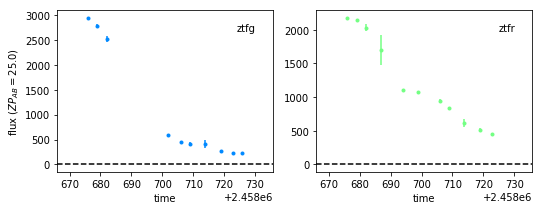

In [9]:
_ = sncosmo.plot_lc(lcs[6])

The two figures below show how early the MNe are detected and at what redshifts. The simulation input parameters of transients that were not detected are also kept, so can check completeness. 

In [10]:
# from scipy.stats import norm
# import matplotlib.mlab as mlab

# heights, bins = np.histogram(lcs.stats['p_det'], range=(-20, 5), bins=25)
# mean, sigma = norm.fit(lcs.stats['p_det'])
# fit = mlab.normpdf(bins, mean, sigma)
# print (1 / fit)
# ax1.plot(bins, fit, c='r', ls='--', lw=1, label='_nolegend_')


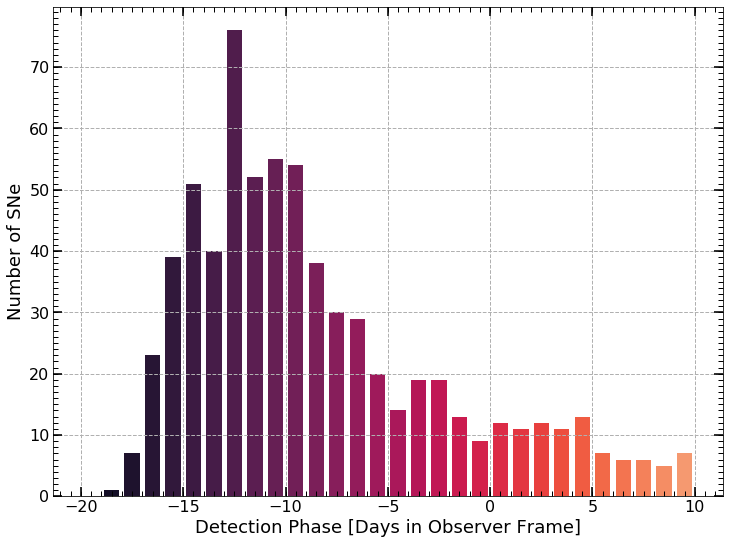

In [11]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(-20, 10), bins=30)
centers = (bins[:-1] + bins[1:]) / 2

ax1.bar(centers, heights, width=0.75, color=sns.color_palette('rocket', int(len(bins) * 1.2)))
# ax1.hist(lcs.stats['p_det'], histtype='bar', rwidth=0.75, color='dimgrey', range=(-20, 8), bins=28)

ax1.grid(True, which='major', ls='--', lw=1)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

ax1.set_xlabel('Detection Phase [Days in Observer Frame]', fontsize=18)
ax1.set_ylabel('Number of SNe', fontsize=18)

fig1.savefig('PLOT_IaDetectionPhaseDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig1)

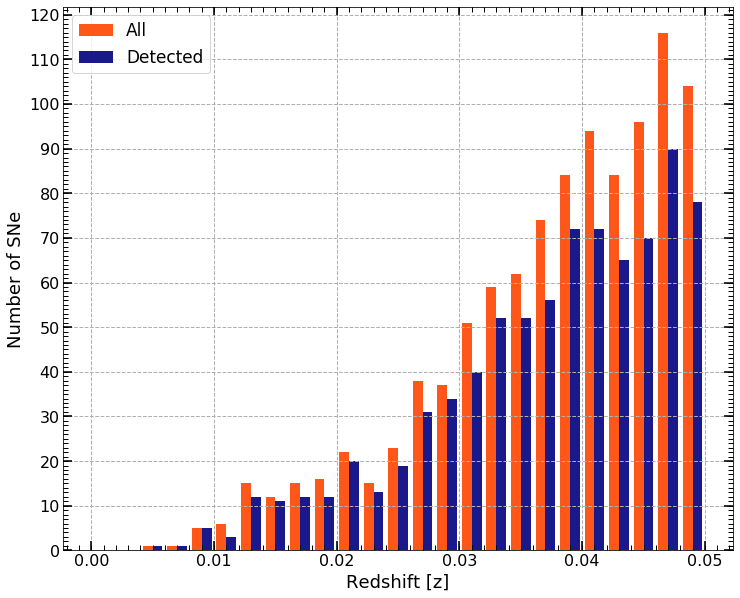

In [12]:
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111)

zhsfull, zbinsfull = np.histogram(lcs.meta_full['z'], range=(0, 0.05), bins=25)
zcentersfull = (zbinsfull[:-1] + zbinsfull[1:]) / 2
zhs, zbins = np.histogram(lcs.meta['z'], range=(0, 0.05), bins=25)
zcenters = (zbins[:-1] + zbins[1:]) / 2

ax2.bar(zcentersfull - 0.0004, zhsfull, width=0.0008, alpha=0.9, color='orangered', label='All')
ax2.bar(zcenters + 0.0004, zhs, width=0.0008, alpha=0.9, color='navy', label='Detected')

# ax2.hist(lcs.meta_full['z'], lw=2, ls='-', histtype='step', color='orangered', range=(0,0.05), bins=25, label='All')
# ax2.hist(lcs.meta['z'], lw=2, ls='-', histtype='step', color='navy', range=(0, 0.05), bins=25, label='Detected')

ax2.legend(fontsize=17, loc=2)
ax2.grid(True, which='major', ls='--', lw=1)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(0.01))
ax2.xaxis.set_minor_locator(MultipleLocator(0.001))
ax2.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax2.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

ax2.set_xlabel('Redshift [z]', fontsize=18)
ax2.set_ylabel('Number of SNe', fontsize=18)

fig2.savefig('PLOT_IaRedshiftDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)


In [13]:
# # ------------------------------------------------------------------------------------------------------------------- #
# # Test Code To Find The Faulty ZTF Data
# # ------------------------------------------------------------------------------------------------------------------- #
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
# idx_range = raw_df.index.values
# val_range = np.array_split(idx_range, 1000)

# for val in val_range:
#     try:
#         raw_df = mod_df(pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[val])
#         plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})
#     except IndexError:
#         print (val)
#         import sys
#         sys.exit(1)
#     else:
#         continue
    
# # ------------------------------------------------------------------------------------------------------------------- #

In [14]:
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[3906128:3906135]
# raw_df = mod_df(raw_df)
# print (raw_df)
# plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})